In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.animation as ma
import pymysql
import time 
from datetime import datetime,timedelta

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
db = pymysql.connect(host="localhost",
                    user="root",
                    password="a123456",
                    port=3306,
                    database="cwddb2",
                    charset="utf8")
cur = db.cursor()

In [3]:
cur.execute("select * from data")
data = cur.fetchall()
df = pd.DataFrame(i for i in data).drop(columns=0)
cols = ["時間","實際溫度","體感溫度","露點溫度","相對溼度%","降雨機率%","風向描述","天氣狀況","舒適度指數","風速(m/s)"]
df.columns = cols

In [4]:
#去重
df.drop_duplicates(subset="時間", keep='last', inplace=True)
df.index = range(len(df))

In [5]:
def h_time(target):
    h_time = ''
    if 0 <= target < 3:
        h_time = "00"
    elif 3 <=target < 6:
        h_time = "03"
    elif 6 <= target < 9:
        h_time = "06"
    elif 9 <= target < 12:
        h_time = "09"
    elif 12 <= target < 15:
        h_time = "12"
    elif 15 <= target < 18:
        h_time = "15"
    elif 18 <= target < 21:
        h_time = "18"
    elif 21 <= target :
        h_time = "21"
    return h_time
    

In [6]:
df.head()

,時間,實際溫度,體感溫度,露點溫度,相對溼度%,降雨機率%,風向描述,天氣狀況,舒適度指數,風速(m/s)
0,2020-03-24 12:00:00,26,25,19,66,10,偏東風,多雲,24,4
1,2020-03-24 15:00:00,26,27,20,72,10,偏東風,多雲,24,5
2,2020-03-24 18:00:00,24,24,20,79,30,偏東風,短暫陣雨,23,4
3,2020-03-24 21:00:00,23,24,20,84,30,偏東風,短暫陣雨,22,4
4,2020-03-25 00:00:00,22,23,20,85,20,偏東風,多雲,22,3


In [7]:
h0= int(datetime.now().strftime("%H"))
if h0 >  21: 
    now_d_time = int((datetime.now()+timedelta(hours=24)).strftime("%d"))
    now_time = datetime.now().strftime("%Y-%m-{} 00:00:00".format(now_d_time))  
else:
    now_h_time =h_time(h0+3) 
    now_time = datetime.now().strftime("%Y-%m-%d {}:00:00".format(now_h_time))
    
now_time_index = df.loc[df["時間"]==now_time].index[0]
now_time

'2020-03-27 12:00:00'

In [8]:
now_datatime  = datetime.strptime(now_time[:13],"%Y-%m-%d %H")
end_time = (now_datatime+timedelta(hours=48)).strftime("%Y-%m-%d %H:00:00")
end_time_index = df.loc[df["時間"]==end_time].index[0]
end_time

'2020-03-29 12:00:00'

In [9]:
df = df.iloc[now_time_index : end_time_index+1]
df.index = range(len(df))

### 	舒適度指數分為六等級
#### 10以下 為非常寒冷
#### 11-15 為寒冷
#### 16-19 為稍有寒意
#### 20-26 為舒適
#### 27-30 為悶熱
#### 31以上 為易中暑

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   時間       17 non-null     datetime64[ns]
 1   實際溫度     17 non-null     object        
 2   體感溫度     17 non-null     object        
 3   露點溫度     17 non-null     object        
 4   相對溼度%    17 non-null     object        
 5   降雨機率%    17 non-null     object        
 6   風向描述     17 non-null     object        
 7   天氣狀況     17 non-null     object        
 8   舒適度指數    17 non-null     object        
 9   風速(m/s)  17 non-null     object        
dtypes: datetime64[ns](1), object(9)
memory usage: 1.5+ KB


In [11]:
#時間、天氣狀況、風向描述不轉，其他轉int
xlist = ["時間","天氣狀況","風向描述"]

for i in df.columns:
    if i in xlist:
        continue
    else:
        df[i] = df[i].astype("int")
    

In [12]:
#舒適度指數分組
df["舒適度"] = 0
s = df["舒適度指數"]
for i in range(len(df)):
    if s[i] < 10:
        df.loc[i,"舒適度"] = "非常寒冷"
    elif  11 <= s[i] <= 15:
        df.loc[i,"舒適度"] = "寒冷"
    elif  16 <= s[i] <= 19:
        df.loc[i,"舒適度"]  = "稍有寒意"
    elif  20 <= s[i] <= 26:
        df.loc[i,"舒適度"]  = "舒適"
    elif  27 <= s[i] <= 30:
        df.loc[i,"舒適度"]  = "悶熱"
    elif  31 <= s[i] :
        df.loc[i,"舒適度"]  = "易中暑"

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   時間       17 non-null     datetime64[ns]
 1   實際溫度     17 non-null     int32         
 2   體感溫度     17 non-null     int32         
 3   露點溫度     17 non-null     int32         
 4   相對溼度%    17 non-null     int32         
 5   降雨機率%    17 non-null     int32         
 6   風向描述     17 non-null     object        
 7   天氣狀況     17 non-null     object        
 8   舒適度指數    17 non-null     int32         
 9   風速(m/s)  17 non-null     int32         
 10  舒適度      17 non-null     object        
dtypes: datetime64[ns](1), int32(7), object(3)
memory usage: 1.1+ KB


In [14]:
def adjustData():
    global df
    start = df["時間"][0].strftime("%Y-%m-%d %H%M%S")
    index = df["時間"].size-1
    end = df["時間"][index].strftime("%Y-%m-%d %H%M%S")
    plt.xlim(list(df["時間"])[0] - pd.Timedelta(hours=0.3), list(df["時間"])[-1] + pd.Timedelta(hours=0.3))
    plt.xticks(pd.date_range(start, end,freq="3h"))
    plt.gca().xaxis.set_major_formatter(md.DateFormatter("%m/%d(%H:%M)"))
    plt.gcf().autofmt_xdate()   

In [15]:
def split_morn_night():
    low_y = np.ones(df["時間"].shape[0]+1)*-10
    up_y = np.ones(df["時間"].shape[0]+1)*100
    morn = [18 >= int(i.strftime("%H")) >= 6 for i in df["時間"]]
    night = [((18 <= int(i.strftime("%H"))) or (int(i.strftime("%H")) <=6))for i in df["時間"]]
    
    morn.append(True)  if (18 >= int(df["時間"][df["時間"].size-1].strftime("%H"))) else morn.append(False)
    night.append(True) if ((18 <= int(df["時間"][df["時間"].size-1].strftime("%H"))) or (int(df["時間"][df["時間"].size-1].strftime("%H")) <=6)) \
    else night.append(False)
    
    fill_x = [df["時間"][0]-pd.Timedelta(hours = 0.5)]
    for i in df["時間"] :
        new_date =  i+pd.Timedelta(hours = 3)
        fill_x.append(new_date)
    fill_x = pd.Series(fill_x)
    
    plt.fill_between(fill_x- pd.Timedelta(hours=0.2),low_y,up_y,morn,color="red",alpha=0.2)
    plt.fill_between(fill_x- pd.Timedelta(hours=0.14954),low_y,up_y,night,color="blue",alpha=0.2)

In [16]:
def save_image(title):
    index = df["時間"].size - 1
    star_name = int(df["時間"][index].strftime("%Y%m%d")) -3
    end_name = int(df["時間"][index].strftime("%Y%m%d")) 
    plt.savefig('./image/新北市-新莊區%d-%d%s.png'%(star_name,end_name,title))

In [17]:
def ylim_range(title):
    ylim_max = df[title].max()+4
    ylim_min = df[title].min()-4
    return ylim_max,ylim_min

# 體感溫度走勢圖

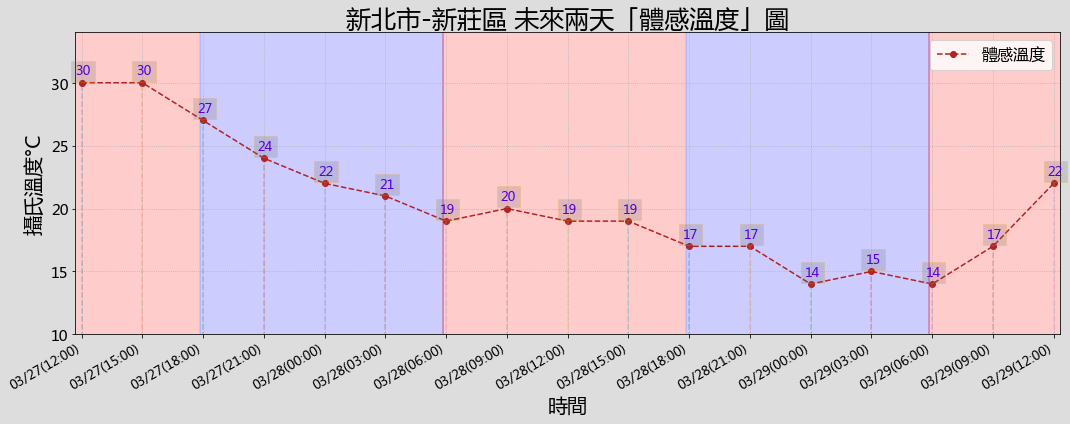

In [18]:
plt.figure(figsize=(15,6),facecolor="#DDDDDD")

plt.plot(df["時間"],df["體感溫度"],"o--",c="#B22222",label="體感溫度")
split_morn_night()

plt.title("新北市-新莊區 未來兩天「體感溫度」圖",fontsize=25)
plt.xlabel("時間",fontsize=20)
plt.ylabel("攝氏溫度°C",fontsize=20)
plt.tick_params(axis="x",labelsize=13)
plt.tick_params(axis="y",labelsize=15)
body_max,body_min = ylim_range("體感溫度")
plt.ylim(body_min,body_max)

bboxTuple = (dict(facecolor="#666666",edgecolor="orange",alpha=0.2),
            dict(facecolor="red",edgecolor="blue",alpha=0.1))
for x, y in zip(df["時間"],df["體感溫度"]):
    xPossition = x - pd.Timedelta(hours=0.3)
    plt.text(xPossition, y+0.65, y,fontsize=13,bbox=bboxTuple[0], color="#5500DD")
    plt.plot([x,x],[0,y],linestyle="--",alpha=0.3)

adjustData()
plt.tight_layout()
plt.grid(linestyle=":")
plt.legend(prop={"size":16})
#匯出
save_image("「體感溫度」圖")




# 新北市-新莊區 未來兩天「體感溫度」與「降雨機率」圖

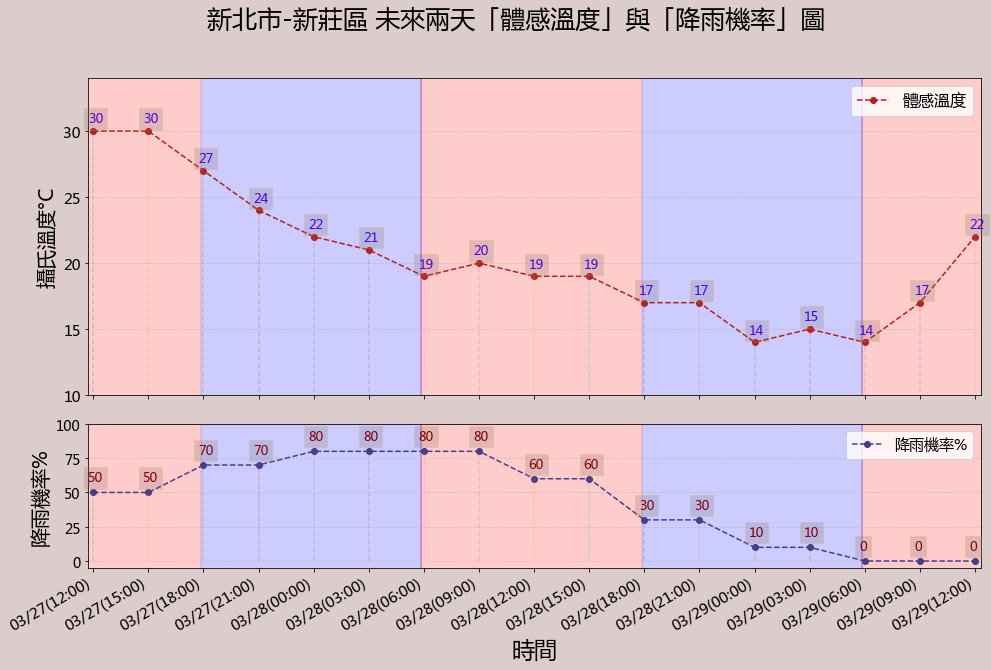

In [19]:
total = plt.figure(figsize=(16,10),facecolor="#DDCCCC")
total.tight_layout()
total.suptitle("新北市-新莊區 未來兩天「體感溫度」與「降雨機率」圖 ",fontsize=25)

ax0 = plt.subplot2grid((3,1),(0,0),rowspan=2)
ax0.plot(df["時間"],df["體感溫度"],"o--",c="#B22222",label="體感溫度")
split_morn_night()
plt.ylabel("攝氏溫度°C",fontsize=20)
plt.tick_params(axis="x",labelsize=13)
plt.tick_params(axis="y",labelsize=15)
plt.ylim(body_min,body_max)

bboxTuple = (dict(facecolor="#666666",edgecolor="orange",alpha=0.2),
            dict(facecolor="red",edgecolor="blue",alpha=0.1))
for x, y in zip(df["時間"],df["體感溫度"]):
    xPossition = x - pd.Timedelta(hours=0.3)
    plt.text(xPossition, y+0.65, y,fontsize=13,bbox=bboxTuple[0], color="#5500DD")
    plt.plot([x,x],[0,y],linestyle="--",alpha=0.2)
    
adjustData()
plt.grid(axis="y",linestyle=":")
plt.legend(prop={"size":16})


ax2 = plt.subplot2grid((3,1),(2,0),rowspan=1)
ax2.plot(df["時間"],df["降雨機率%"],"o--",c="#483D8B",label="降雨機率%")

for x, y in zip(df["時間"],df["降雨機率%"]):
    xPossition = x - pd.Timedelta(hours=0.3)
    plt.text(xPossition, y+8, y,fontsize=13,bbox=bboxTuple[0], color="#880000")
    plt.plot([x,x],[0,y],linestyle="--",alpha=0.2)
    
split_morn_night()
plt.xlabel("時間",fontsize=23)
plt.ylabel("降雨機率%",fontsize=20)
plt.tick_params(axis="x",labelsize=15)
plt.tick_params(axis="y",labelsize=14)
adjustData()
plt.ylim(-5,100)
plt.grid(axis="y",linestyle="--",alpha=0.5)
plt.legend(prop={"size":15})
#匯出
save_image("「體感溫度」與「降雨機率」圖")


# 新北市-新莊區 未來兩天 天氣概況

## 「舒適度指數」係根據每天氣溫及相對濕度的變化，經公式換算所得，分為6種不同等級感受: 非常寒冷、寒冷、稍有寒意、舒適、悶熱及易中暑

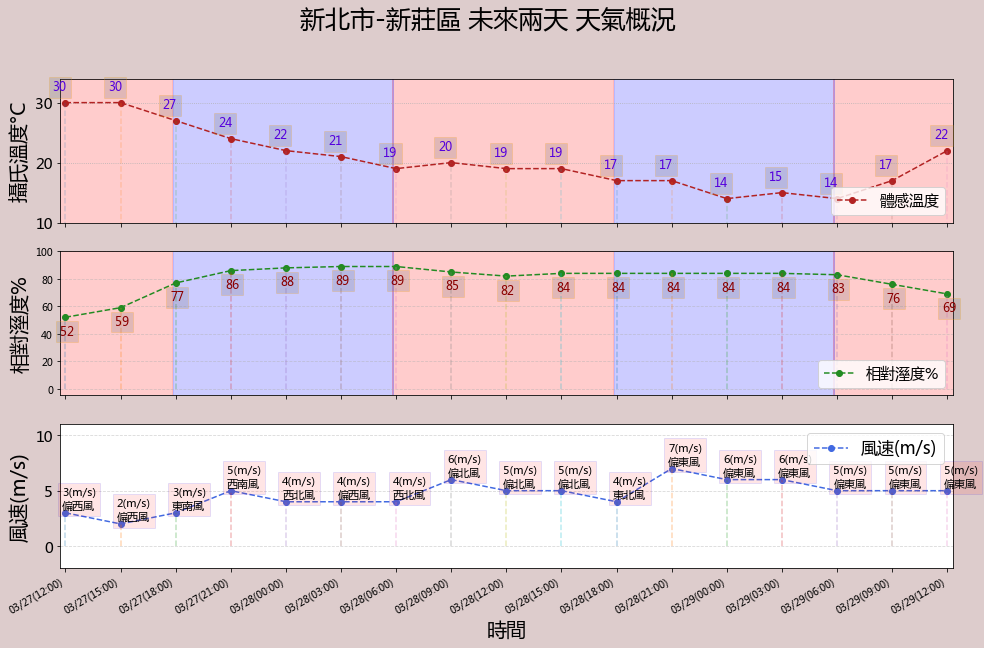

In [20]:
total = plt.figure(figsize=(16,10),facecolor="#DDCCCC")
total.tight_layout()
total.suptitle("新北市-新莊區 未來兩天 天氣概況 ",fontsize=25)

ax0 = plt.subplot2grid((3,1),(0,0),rowspan=1)
ax0.plot(df["時間"],df["體感溫度"],"o--",c="#B22222",label="體感溫度")
split_morn_night()
plt.ylabel("攝氏溫度°C",fontsize=20)
plt.tick_params(axis="x",labelsize=13)
plt.tick_params(axis="y",labelsize=15)
plt.ylim(body_min,body_max)

bboxTuple = (dict(facecolor="#666666",edgecolor="orange",alpha=0.2),
            dict(facecolor="red",edgecolor="blue",alpha=0.1))

for x, y, z,i in zip(df["時間"],df["體感溫度"],df["舒適度"],range(df.size)):
    xPossition = x - pd.Timedelta(hours=0.7)
    xPossition2 = x - pd.Timedelta(hours=0.7)
    plt.text(xPossition, y+2, y,fontsize=12,bbox=bboxTuple[0], color="#5500DD")
        
    plt.plot([x,x],[0,y],linestyle="--",alpha=0.2)
        
adjustData()
plt.grid(axis="y",linestyle=":")
plt.legend(prop={"size":15},loc="lower right")


ax1 = plt.subplot2grid((3,1),(1,0),rowspan=1)
ax1.plot(df["時間"],df["相對溼度%"],"o--",c="#228B22",label="相對溼度%")

for x, y in zip(df["時間"],df["相對溼度%"]):
    xPossition = x - pd.Timedelta(hours=0.3)
    plt.text(xPossition, y-13, y,fontsize=12,bbox=bboxTuple[0], color="#8B0000")
    plt.plot([x,x],[0,y],linestyle="--",alpha=0.3)
    
split_morn_night()
plt.xlabel("時間",fontsize=20)
plt.ylabel("相對溼度%",fontsize=20)
plt.tick_params(axis="x",labelsize=13)
adjustData()
plt.ylim(-5,100)
ax1.grid(axis="y",linestyle="--",alpha=0.5)
plt.legend(prop={"size":15},loc="lower right")


ax2 = plt.subplot2grid((3,1),(2,0),rowspan=1)
ax2.plot(df["時間"],df["風速(m/s)"],"o--",c="#4169E1",label="風速(m/s)")

for x, y, z in zip(df["時間"],df["風速(m/s)"],df["風向描述"]):
    xPossition = x - pd.Timedelta(hours=0.2)
    plt.text(xPossition, y+0.3, "%d(m/s)\n%s"%(y,z),fontsize=11,bbox=bboxTuple[1], color="#000000")
    plt.plot([x,x],[0,y],linestyle="--",alpha=0.3)

# split_morn_night()    
plt.xlabel("時間",fontsize=20)
plt.ylabel("風速(m/s)",fontsize=20)
plt.xticks(())
plt.tick_params(axis="y",labelsize=15)
ws_max, ws_min = ylim_range("風速(m/s)")
plt.ylim(ws_min,ws_max)
ax2.grid(axis="y",linestyle="--",alpha=0.5)

adjustData()

plt.legend(prop={"size":17})
#匯出
save_image("天氣概況")


In [21]:
def adjustData2():
    global df
    start = df["時間"][0].strftime("%Y-%m-%d %H%M%S")
    index = df["時間"].size-1
    end = df["時間"][index].strftime("%Y-%m-%d %H%M%S")
    ax.set_xlim(list(df["時間"])[0] - pd.Timedelta(hours=0.3), list(df["時間"])[-1] + pd.Timedelta(hours=0.3))
    ax.set_xticks(pd.date_range(start, end,freq="3h"))
    ax.xaxis.set_major_formatter(md.DateFormatter("%m/%d(%H:%M)"))
    plt.gcf().autofmt_xdate()   

# matplotlib animation 動態圖

<IPython.core.display.Javascript object>


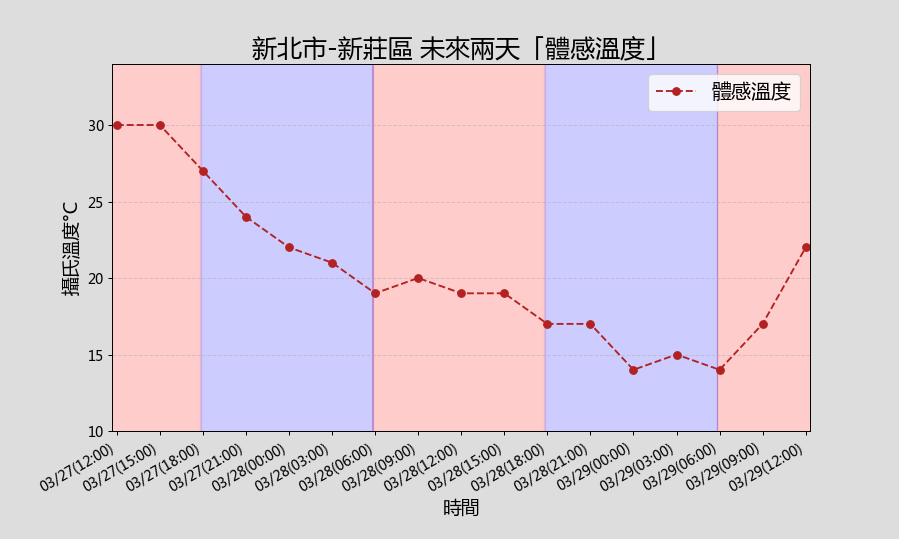

In [27]:
%matplotlib notebook
def init():
    p1.set_data([],[])
    return p1

def update(frames):
    xdata.append(df["時間"][frames])
    p1.set_xdata(xdata)
    y = df["體感溫度"][frames]
    ydata.append(y)
    p1.set_ydata(ydata)
    return p1


fig = plt.figure(figsize=(10,6),facecolor="#DDDDDD")
ax = plt.gca()
xdata, ydata = [],[]
p1 = ax.plot([],[],"o--",c="#B22222",animated=False,label="體感溫度")[0]      
split_morn_night()
adjustData()
ax.set_title("新北市-新莊區 未來兩天「體感溫度」", fontsize=20)
ax.set_xlabel("時間",fontsize=15)
ax.set_ylabel("攝氏溫度°C",fontsize=15)
ax.set_ylim(body_min,body_max)
ax.grid(axis="y",linestyle="--",alpha=0.5)
ax.tick_params(axis="x",labelsize=11)
ax.tick_params(axis="y",labelsize=11)
plt.legend(prop={"size":16})
anim = ma.FuncAnimation(fig,update,frames=17,interval=50, init_func=init,repeat=False)
plt.show(block=False)
plt.pause(10)

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 215, in process
    func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1462, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


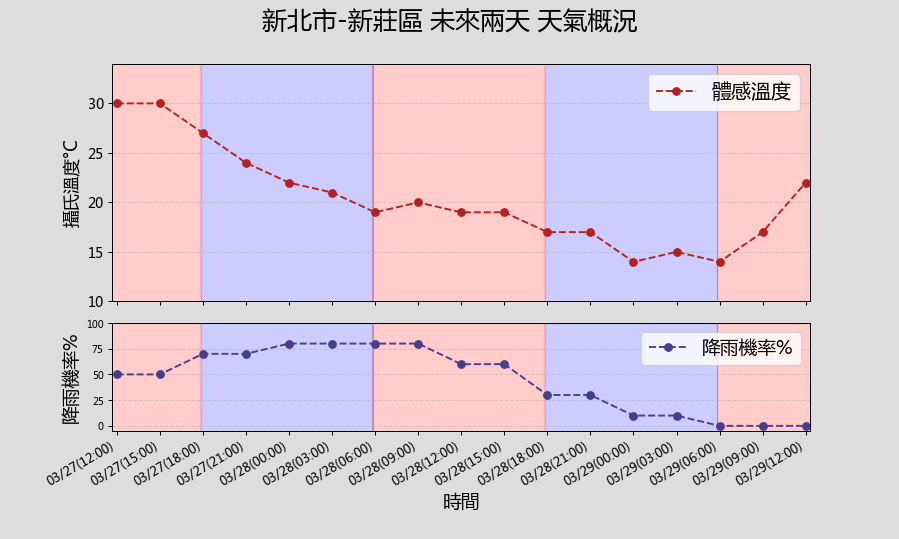

In [23]:
%matplotlib notebook
body_max,body_min = ylim_range("體感溫度")
def init():
    p1.set_data([],[])
    return p1

def update(frames):
    xdata.append(df["時間"][frames])
    xdata2.append(df["時間"][frames])
    p1.set_xdata(xdata)
    p2.set_xdata(xdata2)
    y = df["體感溫度"][frames]
    y2 = df["降雨機率%"][frames]
    ydata.append(y)
    ydata2.append(y2)
    p1.set_ydata(ydata)
    p2.set_ydata(ydata2)
    return p1,p2


fig = plt.figure(figsize=(10,6),facecolor="#DDDDDD")
ax = plt.subplot2grid((3,1),(0,0),rowspan=2)
xdata, ydata = [],[]
p1 = ax.plot([],[],"o--",c="#B22222",animated=False,label="體感溫度")[0]  
split_morn_night()
adjustData()
fig.suptitle("新北市-新莊區 未來兩天 天氣概況", fontsize=20)
ax.set_ylabel("攝氏溫度°C",fontsize=14)
ax.set_ylim(body_min,body_max)
ax.grid(axis="y",linestyle="--",alpha=0.5)
ax.tick_params(axis="x",labelsize=11)
ax.tick_params(axis="y",labelsize=11)
plt.legend(prop={"size":16})
ax2 = plt.subplot2grid((3,1),(2,0),rowspan=1)
xdata2, ydata2 = [],[]
p2 = ax2.plot([],[],"o--",c="#483D8B",label="降雨機率%")[0]
split_morn_night()
adjustData()
ax2.set_xlabel("時間",fontsize=15)
ax2.set_ylabel("降雨機率%",fontsize=15)
plt.tick_params(axis="x",labelsize=10)
plt.tick_params(axis="y",labelsize=8)
ax2.set_ylim(-5,100)
ax2.grid(axis="y",linestyle="--",alpha=0.5)
plt.legend(prop={"size":15})
anim = ma.FuncAnimation(fig,update,frames=17,interval=50, init_func=init,repeat=False)
plt.show(block=False)
plt.pause(10)